## Plots with map and property trend + linear regression

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from shapely.geometry import LineString, Point, MultiPoint, GeometryCollection, MultiLineString
from shapely.ops import unary_union

from pyproj import Geod
from matplotlib.gridspec import GridSpec
from cartopy import crs, feature
from cartopy.feature import NaturalEarthFeature

import warnings
warnings.filterwarnings("ignore")

OUTPATH = './output'
IOPATH = '/ocean/ghoeven/MOAD/Data/PNWCurrent_obs.csv'

## Loading Data and Indicators

In [2]:
obs = pd.read_csv(IOPATH)


In [3]:
# Loading in Climate Indicators

# ENSO
enso = pd.read_csv('/ocean/ghoeven/MOAD/Data/enso1979.csv', names=['year']+[str(x+1) for x in range(12)])

enso = enso.melt(id_vars='year', var_name='month', value_name='index')
enso['month'] = enso['month'].astype(int)
enso = enso.sort_values(['year', 'month']).reset_index(drop=True)

enso['day'] = 1 
enso['time'] = pd.to_datetime(enso[['year', 'month', 'day']])

start_of_year = pd.to_datetime(enso['year'].astype(str) + "-01-01")
end_of_year = pd.to_datetime((enso['year'] + 1).astype(str) + "-01-01")
enso['decimal_yr'] = enso['year'] + (
    (enso['time'] - start_of_year) / 
    (end_of_year - start_of_year)
)

# NPGO
npgo = pd.read_csv('/ocean/ghoeven/MOAD/Data/npgo1950.csv', names=['year', 'month', 'index'])

npgo['day'] = 1 
npgo['time'] = pd.to_datetime(npgo[['year', 'month', 'day']])

start_of_year = pd.to_datetime(npgo['year'].astype(str) + "-01-01")
end_of_year = pd.to_datetime((npgo['year'] + 1).astype(str) + "-01-01")
npgo['decimal_yr'] = npgo['year'] + (
    (npgo['time'] - start_of_year) / 
    (end_of_year - start_of_year)
)

# PDO
pdo = pd.read_csv('/ocean/ghoeven/MOAD/Data/pdo1854.csv', names=['year']+[str(x+1) for x in range(12)])

pdo = pdo.melt(id_vars='year', var_name='month', value_name='index')
pdo['month'] = pdo['month'].astype(int)
pdo = pdo.sort_values(['year', 'month']).reset_index(drop=True)

pdo['day'] = 1 
pdo['time'] = pd.to_datetime(pdo[['year', 'month', 'day']])

start_of_year = pd.to_datetime(pdo['year'].astype(str) + "-01-01")
end_of_year = pd.to_datetime((pdo['year'] + 1).astype(str) + "-01-01")
pdo['decimal_yr'] = pdo['year'] + (
    (pdo['time'] - start_of_year) / 
    (end_of_year - start_of_year)
)


In [4]:
# Setting up different currents
obs_shelf = obs[obs['current'] == 'Shelf_Current']
obs_cuc = obs[obs['current'] == 'CUC']
obs_cc = obs[obs['current'] == 'CC']

## Helper Functions

In [5]:
# From Becca for 
def isobath_lon(lat):
    """
    Return the easternmost longitude of the 2000 m isobath at this latitude.
    Handles Point, MultiPoint, LineString, MultiLineString, and GeometryCollection.
    """
    # build a horizontal scan line across your plotting lon‐range
    scan = LineString([ (xlim[0], lat), (xlim[1], lat) ])
    result = iso2k.intersection(scan)

    # collect candidate points
    pts = []
    if isinstance(result, Point):
        pts = [result]
    elif isinstance(result, MultiPoint):
        pts = list(result.geoms)
    elif isinstance(result, LineString):
        # take both end‐points of the overlap segment
        pts = [Point(c) for c in result.coords]
    elif isinstance(result, MultiLineString):
        # flatten all the segment end‐points
        for seg in result.geoms:
            pts.extend(Point(c) for c in seg.coords)
    elif isinstance(result, GeometryCollection):
        for geom in result.geoms:
            if isinstance(geom, Point):
                pts.append(geom)
            elif isinstance(geom, LineString):
                pts.extend(Point(c) for c in geom.coords)
            elif isinstance(geom, MultiLineString):
                for seg in geom.geoms:
                    pts.extend(Point(c) for c in seg.coords)
    else:
        raise RuntimeError(f"Unexpected intersection type: {type(result)}")

    # filter to the Pacific shelf‐break window and pick the easternmost
    pts = [p for p in pts if -140 < p.x < -115]
    if not pts:
        raise ValueError(f"No 2 000 m isobath found at lat={lat}")
    return max(p.x for p in pts)


def along_track_distance_array(lon_pts, lat_pts):
    """
    Compute signed along-track distances (in km) to both the NS and EW tracks
    for arrays of input points. EW distances are NaN outside of [46.5, 50.5]°N.

    Parameters
    ----------
    lon_pts, lat_pts : array-like
        Arrays of input longitude and latitude points.

    Defined earlier in code
    -----------------------
    lons_NS, lats_NS, d_NS : array-like
        North-south track coordinates and distances.
    lons_EW, lats_EW, d_EW : array-like
        East-west track coordinates and distances.
    geod : pyproj.Geod
        Geodetic calculator.

    Returns
    -------
    d_NS_out : np.ndarray
        Along-track distances (km) to NS track.
    d_EW_out : np.ndarray
        Along-track distances (km) to EW track, NaN outside 46.5–50.5°N.
    """
    lon_pts = np.asarray(lon_pts)
    lat_pts = np.asarray(lat_pts)

    d_NS_out = np.empty_like(lon_pts, dtype=float)
    d_EW_out = np.empty_like(lon_pts, dtype=float)

    ns_max_distance_km = 600
    for i, (lon, lat) in enumerate(zip(lon_pts, lat_pts)):
        # --- NS distance ---
        _, _, dist_NS = geod.inv(
            lons_NS, lats_NS,
            np.full_like(lons_NS, lon),
            np.full_like(lats_NS, lat)
        )
        idx_NS = np.argmin(dist_NS)
        if dist_NS[idx_NS] <= ns_max_distance_km * 1000:
            d_NS_out[i] = d_NS[idx_NS] / 1000.0
        else:
            d_NS_out[i] = np.nan

        # --- EW distance ---
        if 46.5 <= lat <= 50.5:
            _, _, dist_EW = geod.inv(
                lons_EW, lats_EW,
                np.full_like(lons_EW, lon),
                np.full_like(lats_EW, lat)
            )
            idx_EW = np.argmin(dist_EW)
            d_EW_out[i] = d_EW[idx_EW] / 1000.0
        else:
            d_EW_out[i] = np.nan

    return d_NS_out, d_EW_out

def map_line(ax):
    # re-plotting the NS and EW after it is defines in d_EW and d_NS

    ax.plot(lons_NS, lats_NS, '-', transform=crs.PlateCarree(), color='tab:blue', lw=2)
    ax.plot(lons_EW, lats_EW, '-', transform=crs.PlateCarree(), color='tab:orange', lw=2)

    # — 4) place tick-marks every ±1000 km —
    ticks = np.arange(-2000e3, 2000e3 + 1, 500e3)
    for t in ticks:
        # Draw tick on NS leg if in range
        if d_NS.min() <= t <= d_NS.max():
            idx = np.argmin(np.abs(d_NS - t))
            lon_t, lat_t = lons_NS[idx], lats_NS[idx]
            ax.plot([lon_t], [lat_t], marker='.', markersize=4,
                    transform=crs.PlateCarree(), color='k')

        # Draw tick on EW leg if in range
        if d_EW.min() <= t <= d_EW.max():
            idx = np.argmin(np.abs(d_EW - t))
            lon_t, lat_t = lons_EW[idx], lats_EW[idx]
            ax.plot([lon_t], [lat_t], marker='.', markersize=4,
                    transform=crs.PlateCarree(), color='k')

    for t in ticks[::2]:
        if d_NS.min() <= t <= d_NS.max():
            idx = np.argmin(np.abs(d_NS - t))
            lon_t, lat_t = lons_NS[idx], lats_NS[idx]
            ax.text(lon_t, lat_t, f"{int(t/1e3):+d}",
                    transform=crs.PlateCarree(),
                    va='bottom', ha='left', fontsize=10)

        if d_EW.min() <= t <= d_EW.max():
            idx = np.argmin(np.abs(d_EW - t))
            lon_t, lat_t = lons_EW[idx], lats_EW[idx]
            ax.text(lon_t, lat_t, f"{int(t/1e3):+d}",
                    transform=crs.PlateCarree(),
                    va='bottom', ha='right', fontsize=10)

## Figures

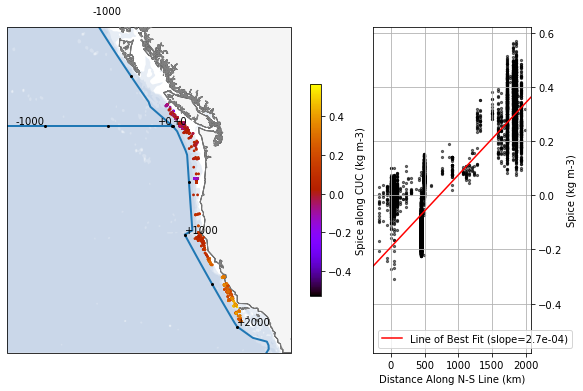

In [6]:
ylim = [30,55]
xlim = [-145,-115]
fig = plt.figure(figsize=(10, 6))
gs = GridSpec(1, 2, width_ratios=[2.5, 1], wspace=0.01)  # Adjust width ratio if needed

# Left panel: Map projection
ax0 = fig.add_subplot(gs[0], projection=crs.Mercator(np.mean(xlim), *ylim))
# Right panel: Standard axes
ax1 = fig.add_subplot(gs[1])

# Make plot area
ax0.set_extent(xlim + ylim)

# Draw coastline
ax0.add_feature(feature.GSHHSFeature('low', facecolor='whitesmoke', zorder=2))
ax0.add_feature(feature.GSHHSFeature('low', edgecolor='grey', zorder=4))

# and bathymetry..?
ax0.add_feature(feature.NaturalEarthFeature(name='bathymetry_K_200', scale='10m', category='physical',facecolor='lightsteelblue',alpha=0.3, zorder=2))
ax0.add_feature(feature.NaturalEarthFeature(name='bathymetry_J_1000', scale='10m', category='physical',facecolor='lightsteelblue',alpha=0.3,zorder=2))
ax0.add_feature(feature.NaturalEarthFeature(name='bathymetry_I_2000', scale='10m', category='physical',facecolor='lightsteelblue',alpha=0.3,zorder=2))

# … coastline & bathymetry here …

# — PARAMETERS —
pivot_lat = 48.5             # switch-over latitude
offset_m = 50e3             # 100 km offshore
tick_km = 2000               # label every 2000 km
leg_samps = 80              # how many points along each leg

# geodesic helper
geod = Geod(ellps='WGS84')

# grab the 2 000 m isobath as a Shapely geometry
iso2k_feature = NaturalEarthFeature(
    category='physical',
    name='bathymetry_I_2000',
    scale='10m',
)
iso2k = unary_union(list(iso2k_feature.geometries()))
iso2k = iso2k.simplify(tolerance=0.8, preserve_topology=True)

# — 1) build the NS (coast-following) leg: from 52°N to 30°N —
lats_NS = np.linspace(57, 30, leg_samps)
lons_NS_coast = np.array([isobath_lon(lat) for lat in lats_NS])

# offset each point 50 km offshore (az=270°)
azs_NS = np.full_like(lons_NS_coast, 270.0)
lons_NS, lats_NS, _ = geod.fwd(lons_NS_coast, lats_NS, azs_NS, np.full(leg_samps, offset_m))

# compute cumulative distances along NS leg (pivot at 48.5N)
_, _, segd_NS = geod.inv(lons_NS[:-1], lats_NS[:-1], lons_NS[1:], lats_NS[1:])
d_NS = np.concatenate([[0], np.cumsum(segd_NS)])

# set 48.5°N as 0 km reference
idx_pivot_NS = np.argmin(np.abs(lats_NS - pivot_lat))
d_NS = d_NS - d_NS[idx_pivot_NS]

# — 2) build the EW leg along pivot_lat (westward from pivot point) —
pivot_lon_coast = isobath_lon(pivot_lat)
pivot_lon_off, pivot_lat_off, _ = geod.fwd(pivot_lon_coast, pivot_lat, 270, offset_m)

lons_EW = np.linspace(pivot_lon_off, xlim[0], leg_samps)
lats_EW = np.full_like(lons_EW, pivot_lat_off)

# compute distances from pivot (negative westward)
_, _, segd_EW = geod.inv(lons_EW[:-1], lats_EW[:-1], lons_EW[1:], lats_EW[1:])
d_EW = -np.concatenate([[0], np.cumsum(segd_EW)])

# — 3) plot both legs —
ax0.plot(lons_NS, lats_NS, '-', transform=crs.PlateCarree(), color='tab:blue', lw=2)
ax0.plot(lons_EW, lats_EW, '-', transform=crs.PlateCarree(), color='tab:blue', lw=2)

# — 4) place tick-marks every ±1000 km —
ticks = np.arange(-2000e3, 2000e3 + 1, 500e3)
for t in ticks:
    # Draw tick on NS leg if in range
    if d_NS.min() <= t <= d_NS.max():
        idx = np.argmin(np.abs(d_NS - t))
        lon_t, lat_t = lons_NS[idx], lats_NS[idx]
        ax0.plot([lon_t], [lat_t], marker='.', markersize=4,
                transform=crs.PlateCarree(), color='k')

    # Draw tick on EW leg if in range
    if d_EW.min() <= t <= d_EW.max():
        idx = np.argmin(np.abs(d_EW - t))
        lon_t, lat_t = lons_EW[idx], lats_EW[idx]
        ax0.plot([lon_t], [lat_t], marker='.', markersize=4,
                transform=crs.PlateCarree(), color='k')

for t in ticks[::2]:
    if d_NS.min() <= t <= d_NS.max():
        idx = np.argmin(np.abs(d_NS - t))
        lon_t, lat_t = lons_NS[idx], lats_NS[idx]
        ax0.text(lon_t, lat_t, f"{int(t/1e3):+d}",
                transform=crs.PlateCarree(),
                va='bottom', ha='left', fontsize=10, zorder=6)

    if d_EW.min() <= t <= d_EW.max():
        idx = np.argmin(np.abs(d_EW - t))
        lon_t, lat_t = lons_EW[idx], lats_EW[idx]
        ax0.text(lon_t, lat_t, f"{int(t/1e3):+d}",
                transform=crs.PlateCarree(),
                va='bottom', ha='right', fontsize=10, zorder=6)


sc = ax0.scatter(obs_cuc['longitude (degrees_east)'], obs_cuc['latitude (degrees_north)'], transform=crs.PlateCarree(), c=obs_cuc['spice'], cmap='gnuplot', s=3, zorder=5)
cbar = fig.colorbar(sc, ax=ax0, orientation='vertical', label='Spice along CUC (kg m-3)', shrink=0.65, aspect=20)


d_NS_out, d_EW_out = along_track_distance_array(obs_cuc['longitude (degrees_east)'], obs_cuc['latitude (degrees_north)'])
m, b = np.polyfit(d_NS_out, obs_cuc['spice'], 1)
xfit = np.arange(min(d_NS_out)-100, max(d_NS_out)+100)
yfit = m*xfit + b

ax1.scatter(d_NS_out, obs_cuc['spice'], s=5, alpha=0.55, c='k')
ax1.plot(xfit,yfit, c='r', label=f'Line of Best Fit (slope={m:.1e})')
ax1.set_xlim([min(d_NS_out)-100, max(d_NS_out)+100])
ax1.set_xlabel('Distance Along N-S Line (km)')
ax1.set_ylabel('Spice (kg m-3)')
ax1.yaxis.set_label_position("right")
ax1.yaxis.tick_right()
ax1.grid()
ax1.legend()
plt.tight_layout()

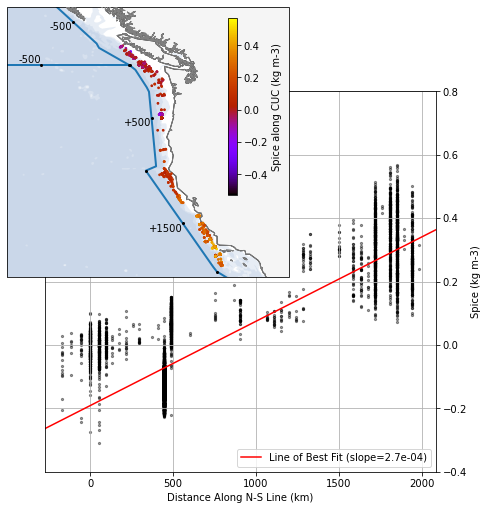

In [7]:
# Main axis
ylim = [32,53]
xlim = [-137,-115]

fig = plt.figure(figsize=(7,7))
ax1 = fig.add_subplot(1, 1, 1)

# Inset Cartopy axis as overlay (coordinates in figure fraction)
left, bottom, width, height = 0.05, 0.43, 0.7, 0.7  # Adjust as needed
ax0 = fig.add_axes([left, bottom, width, height], projection=crs.PlateCarree())

# Make plot area
ax0.set_extent(xlim + ylim)

# Draw coastline
ax0.add_feature(feature.GSHHSFeature('low', facecolor='whitesmoke', zorder=2))
ax0.add_feature(feature.GSHHSFeature('low', edgecolor='grey', zorder=4))

# and bathymetry..?
ax0.add_feature(feature.NaturalEarthFeature(name='bathymetry_K_200', scale='10m', category='physical',facecolor='lightsteelblue',alpha=0.3, zorder=2))
ax0.add_feature(feature.NaturalEarthFeature(name='bathymetry_J_1000', scale='10m', category='physical',facecolor='lightsteelblue',alpha=0.3,zorder=2))
ax0.add_feature(feature.NaturalEarthFeature(name='bathymetry_I_2000', scale='10m', category='physical',facecolor='lightsteelblue',alpha=0.3,zorder=2))

# — 3) plot both legs —
ax0.plot(lons_NS, lats_NS, '-', transform=crs.PlateCarree(), color='tab:blue', lw=2)
ax0.plot(lons_EW, lats_EW, '-', transform=crs.PlateCarree(), color='tab:blue', lw=2)

# — 4) place tick-marks every ±1000 km —
ticks = np.arange(-500e3, 2000e3 + 1, 500e3)
for t in ticks:
    # Draw tick on NS leg if in range
    if d_NS.min() <= t <= d_NS.max():
        idx = np.argmin(np.abs(d_NS - t))
        lon_t, lat_t = lons_NS[idx], lats_NS[idx]
        ax0.plot([lon_t], [lat_t], marker='.', markersize=4,
                transform=crs.PlateCarree(), color='k')

    # Draw tick on EW leg if in range
    if d_EW.min() <= t <= d_EW.max():
        idx = np.argmin(np.abs(d_EW - t))
        lon_t, lat_t = lons_EW[idx], lats_EW[idx]
        ax0.plot([lon_t], [lat_t], marker='.', markersize=4,
                transform=crs.PlateCarree(), color='k')

for t in ticks[::2]:
    if d_NS.min() <= t <= d_NS.max():
        idx = np.argmin(np.abs(d_NS - t))
        lon_t, lat_t = lons_NS[idx], lats_NS[idx]
        ax0.text(lon_t, lat_t, f"{int(t/1e3):+d}",
                transform=crs.PlateCarree(),
                va='top', ha='right', fontsize=10, zorder=6)

    if d_EW.min() <= t <= d_EW.max():
        idx = np.argmin(np.abs(d_EW - t))
        lon_t, lat_t = lons_EW[idx], lats_EW[idx]
        ax0.text(lon_t, lat_t, f"{int(t/1e3):+d}",
                transform=crs.PlateCarree(),
                va='bottom', ha='right', fontsize=10, zorder=6)

sc = ax0.scatter(obs_cuc['longitude (degrees_east)'], obs_cuc['latitude (degrees_north)'], transform=crs.PlateCarree(), c=obs_cuc['spice'], cmap='gnuplot', s=3, zorder=5)
cbar = fig.colorbar(sc, orientation='vertical', label='Spice along CUC (kg m-3)', shrink=0.5, aspect=20, anchor=(-1.8,0.7))


ax1.scatter(d_NS_out, obs_cuc['spice'], s=5, alpha=0.4, c='k')
ax1.plot(xfit,yfit, c='r', label=f'Line of Best Fit (slope={m:.1e})')
ax1.set_xlim([min(d_NS_out)-100, max(d_NS_out)+100])
ax1.set_xlabel('Distance Along N-S Line (km)')
ax1.set_ylabel('Spice (kg m-3)')
ax1.set_ylim([-0.4, 0.8])
ax1.yaxis.set_label_position("right")
ax1.yaxis.tick_right()
ax1.grid()
ax1.legend(loc='lower right')



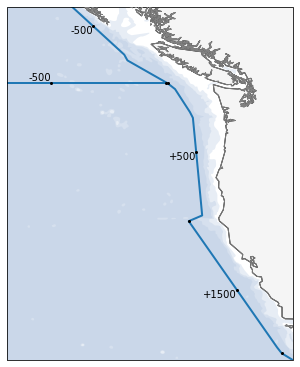

In [8]:
fig = plt.figure(figsize=(7,7))
ax0 = fig.add_axes([left, bottom, width, height], projection=crs.PlateCarree())
# Make plot area
ylim = [32,53]
xlim = [-137,-120]
ax0.set_extent(xlim + ylim)

# Draw coastline
ax0.add_feature(feature.GSHHSFeature('low', facecolor='whitesmoke', zorder=2))
ax0.add_feature(feature.GSHHSFeature('low', edgecolor='grey', zorder=4))

# and bathymetry..?
ax0.add_feature(feature.NaturalEarthFeature(name='bathymetry_K_200', scale='10m', category='physical',facecolor='lightsteelblue',alpha=0.3, zorder=2))
ax0.add_feature(feature.NaturalEarthFeature(name='bathymetry_J_1000', scale='10m', category='physical',facecolor='lightsteelblue',alpha=0.3,zorder=2))
ax0.add_feature(feature.NaturalEarthFeature(name='bathymetry_I_2000', scale='10m', category='physical',facecolor='lightsteelblue',alpha=0.3,zorder=2))

# — 3) plot both legs —
ax0.plot(lons_NS, lats_NS, '-', transform=crs.PlateCarree(), color='tab:blue', lw=2)
ax0.plot(lons_EW, lats_EW, '-', transform=crs.PlateCarree(), color='tab:blue', lw=2)

# — 4) place tick-marks every ±1000 km —
ticks = np.arange(-500e3, 2000e3 + 1, 500e3)
for t in ticks:
    # Draw tick on NS leg if in range
    if d_NS.min() <= t <= d_NS.max():
        idx = np.argmin(np.abs(d_NS - t))
        lon_t, lat_t = lons_NS[idx], lats_NS[idx]
        ax0.plot([lon_t], [lat_t], marker='.', markersize=4,
                transform=crs.PlateCarree(), color='k')

    # Draw tick on EW leg if in range
    if d_EW.min() <= t <= d_EW.max():
        idx = np.argmin(np.abs(d_EW - t))
        lon_t, lat_t = lons_EW[idx], lats_EW[idx]
        ax0.plot([lon_t], [lat_t], marker='.', markersize=4,
                transform=crs.PlateCarree(), color='k')

for t in ticks[::2]:
    if d_NS.min() <= t <= d_NS.max():
        idx = np.argmin(np.abs(d_NS - t))
        lon_t, lat_t = lons_NS[idx], lats_NS[idx]
        ax0.text(lon_t, lat_t, f"{int(t/1e3):+d}",
                transform=crs.PlateCarree(),
                va='top', ha='right', fontsize=10, zorder=6)

    if d_EW.min() <= t <= d_EW.max():
        idx = np.argmin(np.abs(d_EW - t))
        lon_t, lat_t = lons_EW[idx], lats_EW[idx]
        ax0.text(lon_t, lat_t, f"{int(t/1e3):+d}",
                transform=crs.PlateCarree(),
                va='bottom', ha='right', fontsize=10, zorder=6)

## California Current Figure

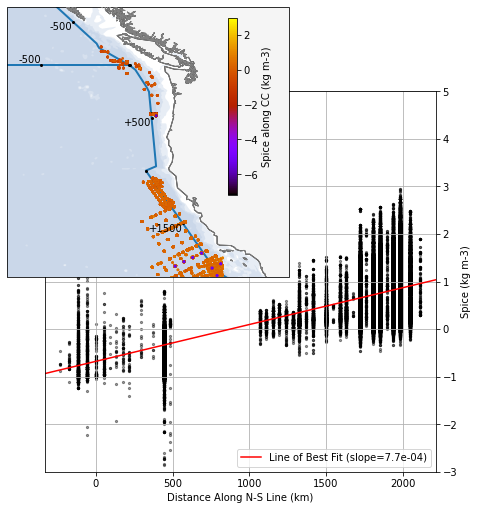

In [9]:
# Main axis
ylim = [32,53]
xlim = [-137,-115]

fig = plt.figure(figsize=(7,7))
ax1 = fig.add_subplot(1, 1, 1)

# Inset Cartopy axis as overlay (coordinates in figure fraction)
left, bottom, width, height = 0.05, 0.43, 0.7, 0.7  # Adjust as needed
ax0 = fig.add_axes([left, bottom, width, height], projection=crs.PlateCarree())

# Make plot area
ax0.set_extent(xlim + ylim)

# Draw coastline
ax0.add_feature(feature.GSHHSFeature('low', facecolor='whitesmoke', zorder=2))
ax0.add_feature(feature.GSHHSFeature('low', edgecolor='grey', zorder=4))

# and bathymetry..?
ax0.add_feature(feature.NaturalEarthFeature(name='bathymetry_K_200', scale='10m', category='physical',facecolor='lightsteelblue',alpha=0.3, zorder=2))
ax0.add_feature(feature.NaturalEarthFeature(name='bathymetry_J_1000', scale='10m', category='physical',facecolor='lightsteelblue',alpha=0.3,zorder=2))
ax0.add_feature(feature.NaturalEarthFeature(name='bathymetry_I_2000', scale='10m', category='physical',facecolor='lightsteelblue',alpha=0.3,zorder=2))

# — 3) plot both legs —
ax0.plot(lons_NS, lats_NS, '-', transform=crs.PlateCarree(), color='tab:blue', lw=2)
ax0.plot(lons_EW, lats_EW, '-', transform=crs.PlateCarree(), color='tab:blue', lw=2)

# — 4) place tick-marks every ±1000 km —
ticks = np.arange(-500e3, 2000e3 + 1, 500e3)
for t in ticks:
    # Draw tick on NS leg if in range
    if d_NS.min() <= t <= d_NS.max():
        idx = np.argmin(np.abs(d_NS - t))
        lon_t, lat_t = lons_NS[idx], lats_NS[idx]
        ax0.plot([lon_t], [lat_t], marker='.', markersize=4,
                transform=crs.PlateCarree(), color='k')

    # Draw tick on EW leg if in range
    if d_EW.min() <= t <= d_EW.max():
        idx = np.argmin(np.abs(d_EW - t))
        lon_t, lat_t = lons_EW[idx], lats_EW[idx]
        ax0.plot([lon_t], [lat_t], marker='.', markersize=4,
                transform=crs.PlateCarree(), color='k')

for t in ticks[::2]:
    if d_NS.min() <= t <= d_NS.max():
        idx = np.argmin(np.abs(d_NS - t))
        lon_t, lat_t = lons_NS[idx], lats_NS[idx]
        ax0.text(lon_t, lat_t, f"{int(t/1e3):+d}",
                transform=crs.PlateCarree(),
                va='top', ha='right', fontsize=10, zorder=6)

    if d_EW.min() <= t <= d_EW.max():
        idx = np.argmin(np.abs(d_EW - t))
        lon_t, lat_t = lons_EW[idx], lats_EW[idx]
        ax0.text(lon_t, lat_t, f"{int(t/1e3):+d}",
                transform=crs.PlateCarree(),
                va='bottom', ha='right', fontsize=10, zorder=6)

d_NS_out, d_EW_out = along_track_distance_array(obs_cc['longitude (degrees_east)'], obs_cc['latitude (degrees_north)'])
m, b = np.polyfit(d_NS_out, obs_cc['spice'], 1)
xfit = np.arange(min(d_NS_out)-100, max(d_NS_out)+100)
yfit = m*xfit + b

sc = ax0.scatter(obs_cc['longitude (degrees_east)'], obs_cc['latitude (degrees_north)'], transform=crs.PlateCarree(), c=obs_cc['spice'], cmap='gnuplot', s=3, zorder=5)
cbar = fig.colorbar(sc, orientation='vertical', label='Spice along CC (kg m-3)', shrink=0.5, aspect=20, anchor=(-1.8,0.7))


ax1.scatter(d_NS_out, obs_cc['spice'], s=5, alpha=0.4, c='k')
ax1.plot(xfit,yfit, c='r', label=f'Line of Best Fit (slope={m:.1e})')
ax1.set_xlim([min(d_NS_out)-100, max(d_NS_out)+100])
ax1.set_xlabel('Distance Along N-S Line (km)')
ax1.set_ylabel('Spice (kg m-3)')
ax1.set_ylim([-3, 5])
ax1.yaxis.set_label_position("right")
ax1.yaxis.tick_right()
ax1.grid()
ax1.legend(loc='lower right')